# Проверка гипотезы о пользовательской активности онлайн библиотеки

## Цели и задачи проекта

**Цель:** Проверить гипотезу сервиса онлайн библиотеки о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

**Задачи:** 
* Провести предобработку датасета
* Проверить корректность распределения экспериментальных групп
* Проверить гипотезу
* Подготовить аналитическую записку и сделать выводы

## Описание данных

У нас имеется предобработанный датасет **`online_library_data.csv`**, содержащий данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности.

Содержание датасета **`online_library_data.csv`**:
* **`city`** - город пользователя
* **`puid`** - идентификатор пользователя
* **`hours`** - общее количество часов активности

## Содержимое проекта

1. Загрузить датасет `online_library_data.csv` и познакомиться с ним
2. Проверить датасет на наличие дубликатов в идентификаторах пользователей
3. Сравнить распределение групп, их размеры и наличие пересечений
4. Проверить гипотезу одним из статистических тестов
5. Подготовить аналитическую записку и сделать выводы

## 1. Загрузка данных и знакомство с ними

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import ttest_ind
from scipy.stats import levene

try:
    from matplotlib_venn import venn2
except:
    !pip install matplotlib-venn
    from matplotlib_venn import venn2
    
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Читаем датасет online_library_data.csv
df_online_library = pd.read_csv('datasets/online_library_data.csv')

In [3]:
# Выводим первые 5 строк датафрейма для ознакомления
df_online_library.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Выведем информацию о датафрейме
df_online_library.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


***В таблице есть столбец `Unnamed: 0` неопределенного происхождения, вероятней всего дублирующий индекс датафрейма. Проверим его на соответствие индексам.***

In [5]:
print(f"Количество строк в датафрейме: {df_online_library.shape[0]}")
print(f"Количество совпадений по столбцу 'Unnamed: 0' c индексами: {(df_online_library['Unnamed: 0'] == df_online_library.index).sum()} ")

Количество строк в датафрейме: 8784
Количество совпадений по столбцу 'Unnamed: 0' c индексами: 8784 


***Теория о соответствии значений в столбце `Unnamed: 0` и индексами датафрейма подтвердилась, можем удалить этот столбец.***

In [6]:
# Удаляем столбец 'Unnamed: 0'
df_online_library = df_online_library.drop('Unnamed: 0', axis=1)

In [7]:
# Проверяем результат
df_online_library.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [8]:
# Проверим наличие дубликатов по идентификатору пользователя
print(f"Количество дублей: {df_online_library['puid'].duplicated().sum()}")

Количество дублей: 244


**Проверим группы на пересечение пользователей**

In [9]:
# Сохраним значения puid для каждой группы в отдельный массив
group_1 = set(df_online_library.loc[df_online_library['city'] == 'Москва', 'puid'])
group_2 = set(df_online_library.loc[df_online_library['city'] == 'Санкт-Петербург', 'puid'])

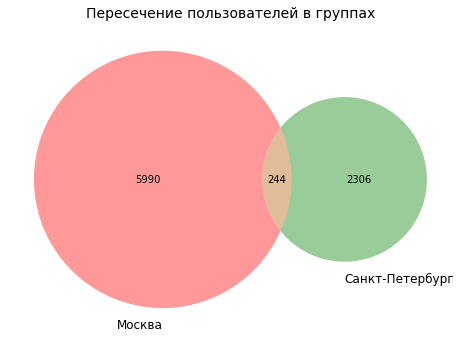

In [10]:
# Построим диаграмму Венна
plt.figure(figsize=(8,8))
venn2([group_1, group_2], set_labels=('Москва', 'Санкт-Петербург'))
plt.title("Пересечение пользователей в группах", fontsize=14)
plt.show()

***244 пользователя попали в обе группы. Очевидно, что и дубликаты по ID пользователя связаны с присутствием одного и того же пользователя в обеих группах (городах). А это нарушает принцип непересечения групп, поэтому этих пользователей стоит исключить из эксперимента.***

In [11]:
# Удаляем пользователей, которые попали в обе группы
df_online_library = df_online_library.drop_duplicates(subset='puid', keep=False)

In [12]:
# Проверяем
print(f"Количество полных дублей: {df_online_library.duplicated().sum()}")
print(f"Количество дублей в столбце puid: {df_online_library['puid'].duplicated().sum()}")
print(f"Общее число пользователей: {df_online_library.shape[0]}")

Количество полных дублей: 0
Количество дублей в столбце puid: 0
Общее число пользователей: 8296


In [13]:
# Посмотрим на распределение групп
count_users = df_online_library.groupby('city')['puid'].nunique().reset_index(name='cnt_users')
count_users

,city,cnt_users
0,Москва,5990
1,Санкт-Петербург,2306


In [14]:
# Рассчитаем как сильно отличаются группы по количеству пользователей
diff_group = 100 * (abs(count_users.iloc[0, 1] - count_users.iloc[1, 1]) / count_users.iloc[0, 1])
print(f"Процентная разница в количестве пользователей в группах составляет: {diff_group:.2f}%")

Процентная разница в количестве пользователей в группах составляет: 61.50%


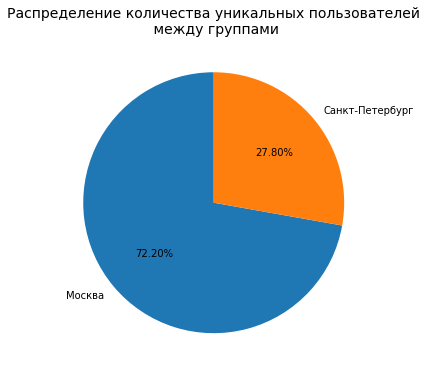

In [15]:
# Строим круговую диаграмму распределения экспериментальных групп
plt.figure(figsize=(8, 6))

plt.pie(count_users['cnt_users'],
        labels=['Москва', 'Санкт-Петербург'],
        autopct='%.2f%%',
        startangle=90
       )
plt.title('Распределение количества уникальных пользователей\n между группами', fontsize=14)
plt.show()

***Пользователей в группе "Санкт-Петербург" на 61.5% меньше, чем в группе "Москва". В группе "Москва" 5990 пользователей (72%), а в группе "Санкт-Петербург" 2306 пользователей (28%)***

In [16]:
# Выводим статистики для каждой из групп
print('Статистики для группы "Москва"')
display(df_online_library[df_online_library['city'] == 'Москва']['hours'].describe())
print('Статистики для группы "Санкт-Петербург"')
display(df_online_library[df_online_library['city'] == 'Санкт-Петербург']['hours'].describe())

Статистики для группы "Москва"


count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

Статистики для группы "Санкт-Петербург"


count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

In [17]:
hours_msc_var = df_online_library[df_online_library['city'] == 'Москва']['hours']
hours_spb_var = df_online_library[df_online_library['city'] == 'Санкт-Петербург']['hours']

print(f"Дисперсия для группы 'Москва': {hours_msc_var.var():.2f}")
print(f"Дисперсия для группы 'Санкт-Петербург': {hours_spb_var.var():.2f}")

Дисперсия для группы 'Москва': 1363.50
Дисперсия для группы 'Санкт-Петербург': 1586.57


**Москва:** Среднее количество часов - 10.85, Стандартное отклонение - 36.93, Дисперсия - 1363.50\
**Санкт-Петербург:** Среднее количество часов - 11.26, Стандартное отклонение - 39.83, Дисперсия - 1586.57

In [18]:
# Проверим статистически равенство дисперсий двух групп тестом Левена
alpha = 0.05  # уровень значимости

# Тест Левена
statistic, p_value = levene(hours_msc_var, hours_spb_var)

print(f"Статистика теста: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результата
if p_value > alpha:
    print("Нет оснований отвергнуть нулевую гипотезу: дисперсии равны")
else:
    print("Отвергаем нулевую гипотезу: дисперсии не равны")

Статистика теста: 0.2025
P-value: 0.6527
Нет оснований отвергнуть нулевую гипотезу: дисперсии равны


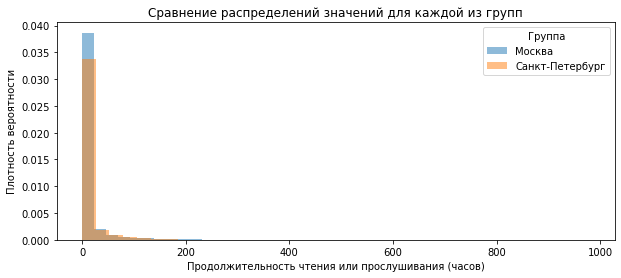

In [19]:
# Построим на графике распределение для обеих групп 
plt.figure(figsize=(10, 4))

# Строим гистограммы для каждого значения churn
for i in df_online_library['city'].unique():
    # Фильтруем данные по значению столбца churn
    df_online_library.loc[df_online_library['city'] == i, 'hours'].plot(
        kind='hist',
        density=True,
        bins=37,
        alpha=0.5,
        label=f'{i}',
        legend=True
    )

# Настраиваем внешний вид графика и выводим его на экран
plt.title(f'Сравнение распределений значений для каждой из групп')
plt.xlabel('Продолжительность чтения или прослушивания (часов)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Группа')
plt.show()

***Обе группы имеют тяжелые хвосты и сильно смещены влево, что говорит о наличии аномальных значений и выбросов***

## 2. Проверка гипотезы

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [20]:
# Сохраним значения каждой группы в отдельный список
group_1_msc = df_online_library[df_online_library['city'] == 'Москва']['hours']
group_2_spb = df_online_library[df_online_library['city'] == 'Санкт-Петербург']['hours']

# Устанавливаем уровень значимости
alpha = 0.05

# Проверяем гипотезу 
results = st.ttest_ind(
    group_1_msc, 
    group_2_spb,
    equal_var = False,
    alternative='less'
)

print(f"Значение p-value: {results.pvalue:.4f}")

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value: 0.3318
Не получилось отвергнуть нулевую гипотезу


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



***Параметры группы Москва:***
* Размер выборки: 5990
* Среднее количество часов: 10.85
* Дисперсия: 1363.50
* Стандартное отклонение: 36.93

***Параметры группы Санкт-Петербург:***
* Размер выборки: 2306
* Среднее количество часов: 11.26
* Дисперсия: 1586.57
* Стандартное отклонение: 39.83

***Для проверки гипотезы использовался t-тест Уэлча, т.к. наблюдается различие в выборочных дисперсиях двух групп.***\
***Уровень значимости установлен в размере 5% (a = 0.05).***

***Результат статистического теста:***\
Среднее количество часов для пользователей Санкт-Петербурга выше чем у пользователей Москвы на 0,41 (~3,78%)\
P-value = 0.33, что больше установленного уровня значимости (0,05), следовательно разность средних двух групп не является статистически значимым и нет достаточных оснований отклонять нулевую гипотезу в пользу альтернативной.

***Вывод: Среднее время пользователей из Санкт-Петербурга и Москвы, проведенное за чтением и прослушиванием книг в приложении, статистически не различается.***

***Возможные причины полученных результатов:*** 
* Разность размера выборок.
* Наличие тяжелых хвостов и выбросов